In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import operators
import lowlevelheuristics

In [2]:
def fitness(results):
    fitnesss = []
    lengths = []
    for idx, result in enumerate(results):
        fitnesss.append(np.sum(np.square(np.array(result) / BIN_CAPACITYS[idx])) / len(result))
        lengths.append(len(result))
    
    return np.mean(fitnesss)

In [3]:
def applyChromosome(problemsItems, chromosome):
    results = []
    
    for pIdx, items in enumerate(problemsItems):
        result = []
        idx = 0
        while idx < len(items):
            for heuristic in chromosome:
                if idx < len(items):
                    heuristic(result, items[idx], BIN_CAPACITYS[pIdx])
                    idx += 1
                else:
                    break
        results.append(result)
            
    return results

In [4]:
def generateChromosome():
    chromosome = []
    chromosomeLength = np.random.randint(low=MIN_CHROMOSOME_SIZE,high=MAX_CHROMOSOME_SIZE)
    for i in range(chromosomeLength):
        heuristicChoice = np.random.randint(len(heuristicList))
        chromosome.append(heuristicList[heuristicChoice])
        
    return chromosome

In [5]:
def createPopulation():
    population = []
    for i in range(POPULATION_SIZE):
        population.append(generateChromosome())
        
    return population

In [6]:
def getPopulationFitness(population):
    populationResults = []
    for individual in population:
        populationResults.append(applyChromosome(problemsItems, individual))
        
    populationFitness = []
    for idx, result in enumerate(populationResults):
        populationFitness.append(fitness(result))
    
    return np.array(populationFitness), populationResults

In [7]:
def tournamentSelector(population, tournament_size=5):
    # Make the tournament
    random_indicies = np.random.randint(len(population), size=tournament_size).tolist()
    tournament = []
    for idx, val in np.ndenumerate(random_indicies):
        tournament.append(population[val])

    # Run the tournament
    fitnesss, results = getPopulationFitness(tournament)
    
    maxPos = np.argmax(fitnesss, axis=0)
    minPos = np.argmin(fitnesss, axis=0)
    
    return [random_indicies[maxPos], fitnesss[maxPos]], [random_indicies[minPos], fitnesss[minPos]]

A genetic algorithm that mutates by doing swap operations 2 times and does a crossover operation at 2 points

In [8]:
def geneticAlgorithm(population):
    newPop = population[:]
    
    for i in range(NUM_MUTATE):    
        best, worst = tournamentSelector(population, tournament_size=TOURNAMENT_SIZE)
        newPop[worst[0]] = operators.swap(population[best[0]], 1)
        
    for i in range(NUM_CROSSOVER):    
        best1, worst1 = tournamentSelector(population, tournament_size=TOURNAMENT_SIZE)
        best2, worst2 = tournamentSelector(population, tournament_size=TOURNAMENT_SIZE)
        result1, result2 = operators.crossover(population[best1[0]], population[best2[0]], 1)
        newPop[worst1[0]] = result1
        newPop[worst2[0]] = result2
    
    return newPop

In [9]:
def geneticAlgorithm2(population):
    newPop = []
    
    for i in range(NUM_MUTATE):    
        best, worst = tournamentSelector(population, tournament_size=TOURNAMENT_SIZE)
        newPop.append(operators.swap(population[best[0]], 1))
        
    for i in range(NUM_CROSSOVER):    
        best1, worst1 = tournamentSelector(population, tournament_size=TOURNAMENT_SIZE)
        best2, worst2 = tournamentSelector(population, tournament_size=TOURNAMENT_SIZE)
        result1, result2 = operators.crossover(population[best1[0]], population[best2[0]], 1)
        newPop.append(result1)
        newPop.append(result2)
        
    for i in range(NUM_REPRODUCTION):    
        best, worst = tournamentSelector(population, tournament_size=TOURNAMENT_SIZE)
        newPop.append(population[best[0]])
    
    return newPop

In [10]:
def tabooSearch(current):
    operator = operatorList[np.random.randint(len(operatorList))]
    new = operator(current, heuristicList, 1)
    
    if new in tabooList:
        return current
    if fitness(applyChromosome(problemsItems, new)) > fitness(applyChromosome(problemsItems, current)):
        current = new
    
    tabooList.append(new)
    
    return current

Genetic Algorithm:
Sample 1: 0.867987065934066
Sample 2: 0.867987065934066
Tabu Search:
Sample 1: 0.8676904986263736
Sample 2: 0.867987065934066
Genetic Algorithm Final: 0.867987065934066
Tabu Search Final: 0.8678387822802198


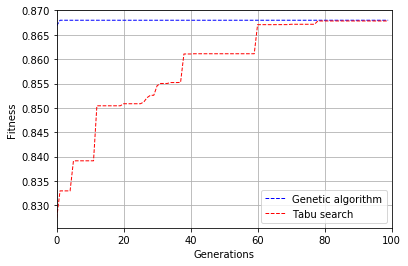

In [11]:
location = './problems/'

problems = [
            ['bin1data/N1C1W1_A.BPP', 25],
            ['bin1data/N1C1W1_O.BPP', 32],
            ['bin1data/N1C1W1_P.BPP', 26],
            ['bin1data/N1C1W1_T.BPP', 28],
            ['bin1data/N1C1W1_G.BPP', 25],
            ['bin1data/N1C1W1_K.BPP', 26],
            ['bin1data/N1C1W1_S.BPP', 28],
            ['bin1data/N1C1W1_F.BPP', 27],
    
            ['bin2data/N1W1B1R0.BPP', 18],
            ['bin2data/N1W1B1R1.BPP', 18],
            ['bin2data/N1W2B3R2.BPP', 10]
        ]

heuristicList = [
    lowlevelheuristics.firstFit,
    lowlevelheuristics.nextFit,
    lowlevelheuristics.bestFit,
    lowlevelheuristics.worstFit
]

problemIndexs = [3, 4, 5, 8]
problemsItems = []
PROBLEM_SIZES = []
BIN_CAPACITYS = []
for idx, problemIndex in enumerate(problemIndexs):
    problemSet = pd.read_csv(location + problems[problemIndex][0], header=None).values.tolist()

    PROBLEM_SIZES.append(problemSet.pop(0)[0])
    BIN_CAPACITYS.append(problemSet.pop(0)[0])

    items = pd.DataFrame(problemSet)
    items = np.array(items[0])
    items = -np.sort(-items)

    assert PROBLEM_SIZES[idx] == len(items)
    
    problemsItems.append(items)

MIN_CHROMOSOME_SIZE = 10
MAX_CHROMOSOME_SIZE = max(PROBLEM_SIZES)

POPULATION_SIZE = 30
GENERATIONS = 100
TOURNAMENT_SIZE = 3

MUTATION_RATE = 0.5
CROSSOVER_RATE = 0.3

NUM_MUTATE = int(MUTATION_RATE * POPULATION_SIZE)
NUM_CROSSOVER = int(CROSSOVER_RATE * POPULATION_SIZE)
NUM_REPRODUCTION = POPULATION_SIZE - (NUM_MUTATE + NUM_CROSSOVER)

assert NUM_REPRODUCTION >= 0

SAMPLES = 30

REPORT_RATE = 1

samplesGaOverTime = []
samplesGaFinal = []

print("Genetic Algorithm:")
for sample in range(SAMPLES):
    gaOverTime = []
    population = createPopulation()
    for gen in range(GENERATIONS):    
        population = geneticAlgorithm2(population)

        if gen % REPORT_RATE == 0:
            fitnesss, results = getPopulationFitness(population)
            max = np.argmax(fitnesss, axis=0)
            gaOverTime.append(fitnesss[max])
            #print(fitnesss[max])
            
    samplesGaOverTime.append(gaOverTime)
    fitnesss, results = getPopulationFitness(population)
    finalFitness = fitnesss[np.argmax(fitnesss, axis=0)]
    samplesGaFinal.append(finalFitness)
    print("Sample " + str(sample + 1) + ": " + str(finalFitness))
    

operatorList = [
    operators.add,
    operators.change,
    operators.remove,
    operators.swap
]

tabooList = []

samplesTabuOverTime = []
samplesTabuFinal = []

print("Tabu Search:")
for sample in range(SAMPLES):
    tabuOverTime = []
    current = generateChromosome()
    for gen in range(GENERATIONS):    
        current = tabooSearch(current)

        if gen % REPORT_RATE == 0:
            result = fitness(applyChromosome(problemsItems, current))
            tabuOverTime.append(result)
            
    samplesTabuOverTime.append(tabuOverTime)
    finalFitness = fitness(applyChromosome(problemsItems, current))
    samplesTabuFinal.append(finalFitness)
    print("Sample " + str(sample + 1) + ": " + str(finalFitness))
        
generations = np.arange(int(GENERATIONS/REPORT_RATE))

meanGaOverTime = np.mean(samplesGaOverTime, axis=0)
meanTabuOverTime = np.mean(samplesTabuOverTime, axis=0)

meanGaFinal = np.mean(samplesGaFinal)
meanTabuFinal = np.mean(samplesTabuFinal)

print("Genetic Algorithm Final: " + str(meanGaFinal))
print("Tabu Search Final: " + str(meanTabuFinal))

fig = plt.figure()
plt.grid(1)
plt.xlim([0, GENERATIONS])
plt.ion()
plt.xlabel('Generations')
plt.ylabel('Fitness')

plots = []
descriptions = []
plots.append(plt.plot(generations, meanGaOverTime, 'b--', linewidth=1, markersize=3)[0])
plots.append(plt.plot(generations, meanTabuOverTime, 'r--', linewidth=1, markersize=3)[0])
descriptions.append("Genetic algorithm")
descriptions.append("Tabu search")

plt.legend(plots, descriptions)
fig.savefig('Result.png')
plt.show(5)

plt.close()
